# Recalculating Class

In [ ]:
import os
os.chdir("/Users/jen/watttime-python-client")

from watttime.api import WattTimeForecast, WattTimeOptimizer
import pandas as pd
from datetime import datetime, timedelta
from pytz import UTC
from typing import Optional

OPT_INTERVAL = 5
MAX_PREDICTION_HOURS = 72

class Recalculator:
    ''' Functions critical to maintain an updated charging schedule'''
    def __init__(
        self,
        initial_schedule: pd.DataFrame,
        start_time: datetime,
        end_time: datetime,
        total_time_required: int
    ) -> None:

        self.all_schedules = [(initial_schedule, (start_time, end_time))]  # (schedule, ctx)
        self.total_time_required = total_time_required
        self.end_time = end_time

    def get_remaining_time_required(self, next_query_time: datetime):
        if len(self.all_schedules) == 0:
            return self.total_time_required

        # If there are previously produced schedules, assume we followed each schedule until getting a new one
        combined_schedule = self.get_combined_schedule()

        # Calculate remaining time required
        usage_in_minutes = int(
            combined_schedule[combined_schedule.index < next_query_time]["usage"].sum()
        )
        return self.total_time_required - usage_in_minutes
    
    def set_last_schedule_end_time(self, new_schedule_start_time: datetime):
        # If there a previously produced schedule, assume we followed that schedule until getting the new one
        if len(self.all_schedules) > 0:
            # Set end time of last ctx
            schedule, ctx = self.all_schedules[-1]
            print(ctx[0])
            print(new_schedule_start_time)
            self.all_schedules[-1] = (schedule, (ctx[0], new_schedule_start_time))
            assert ctx[0] < new_schedule_start_time

    def update_charging_schedule(
            self,
            new_schedule: pd.DataFrame,
            new_schedule_start_time: datetime
        ):
        self.set_last_schedule_end_time(new_schedule_start_time)
        self.all_schedules.append((new_schedule, (new_schedule_start_time, self.end_time)))
                                               
    def get_combined_schedule(self, end_time: datetime = None) -> pd.DataFrame:
        schedule_segments = []
        for s, ctx in self.all_schedules:
            schedule_segments.append(s[s.index < ctx[1]])
        combined_schedule = pd.concat(schedule_segments)

        if end_time:
            # Only keep segments that complete before end_time
            last_segment_start_time = end_time + timedelta(minutes=OPT_INTERVAL)
            combined_schedule = combined_schedule[
                combined_schedule.index <= last_segment_start_time
            ]

        return combined_schedule
    
def get_forecast_dataframe(
          start_time: datetime = datetime(2025, 1, 1, hour=20, second=1, tzinfo=UTC),
          end_time: datetime = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC),
          horizon_hours: int = 12,
          region: str = 'CAISO_NORTH'
        ) -> pd.DataFrame:
        try:
            username = os.getenv("WATTTIME_USER")
            password = os.getenv("WATTTIME_PASSWORD")
            
            if not username or not password:
                raise ValueError("WattTime credentials not found in environment variables")
                
            wth = WattTimeForecast(username=username, password=password)
            
            forecast_dataframe = wth.get_historical_forecast_pandas(
                start=start_time - timedelta(minutes=5),
                end=end_time,
                region=region,
                signal_type="co2_moer",
                horizon_hours=horizon_hours
            )
        except Exception as e:
            raise RuntimeError(f"Error retrieving forecast data: {str(e)}")
        
        return forecast_dataframe

## Testing on historical forecast data

In [ ]:
moers = get_forecast_dataframe()
requery_dates = moers.generated_at.unique()[0::4] # every 20 minutes

moers_list = []
for d in requery_dates:
    moers_list.append(moers[moers.generated_at == d])

In [ ]:
def simulate_requery_process(
        moers_list,
        requery_dates,
        region = "CAISO_NORTH",
        window_start = datetime(2025, 1, 1, hour=20, second=1, tzinfo=UTC),
        window_end = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC),
        usage_time_required_minutes = 240,
        usage_power_kw = 2
        ):
    
    username = os.getenv("WATTTIME_USER")
    password = os.getenv("WATTTIME_PASSWORD")
    
    wt_opt = WattTimeOptimizer(username,password)
    usage_plan = wt_opt.get_optimal_usage_plan(
        region=region,
        usage_window_start=window_start,
        usage_window_end=window_end,
        usage_time_required_minutes=usage_time_required_minutes,
        usage_power_kw=usage_power_kw,
        charge_per_interval= None,
        optimization_method="simple",
        moer_data_override=moers_list[0][["point_time","value"]]
        )
    
    r = Recalculator(
        initial_schedule=usage_plan,
        start_time=window_start,
        end_time=window_end,
        total_time_required=usage_time_required_minutes
        )
    
    i = 0
    for d in requery_dates[1:]:
        i+=1
        print(i)
        new_window_start = d
        new_usage_time_required_minutes = r.get_remaining_time_required(new_window_start)
        next_usage_plan = wt_opt.get_optimal_usage_plan(
            region=region,
            usage_window_start=new_window_start,
            usage_window_end=window_end,
            usage_time_required_minutes=new_usage_time_required_minutes,
            usage_power_kw=usage_power_kw,
            # Here _None_ implies that there is no upper bound, and replacing None by 120 would have the exact same effect.
            charge_per_interval= None,
            optimization_method="simple",
            moer_data_override=moers_list[i][["point_time","value"]]
            )
        r.update_charging_schedule(new_schedule=next_usage_plan,new_schedule_start_time=new_window_start)
        
    return r
    

In [97]:
fitted_recalculator = simulate_requery_process(moers_list=moers_list, requery_dates=requery_dates)

None
== Simple fit! ==
1
None
== Simple fit! ==
2025-01-01 20:00:01+00:00
2025-01-01 20:20:00+00:00
2
None
== Simple fit! ==
2025-01-01 20:20:00+00:00
2025-01-01 20:40:00+00:00
3
None
== Simple fit! ==
2025-01-01 20:40:00+00:00
2025-01-01 21:00:00+00:00
4
None
== Simple fit! ==
2025-01-01 21:00:00+00:00
2025-01-01 21:20:00+00:00
5
None
== Simple fit! ==
2025-01-01 21:20:00+00:00
2025-01-01 21:40:00+00:00
6
None
== Simple fit! ==
2025-01-01 21:40:00+00:00
2025-01-01 22:00:00+00:00
7
None
== Simple fit! ==
2025-01-01 22:00:00+00:00
2025-01-01 22:20:00+00:00
8
None
== Simple fit! ==
2025-01-01 22:20:00+00:00
2025-01-01 22:40:00+00:00
9
None
== Simple fit! ==
2025-01-01 22:40:00+00:00
2025-01-01 23:00:00+00:00
10
None
== Simple fit! ==
2025-01-01 23:00:00+00:00
2025-01-01 23:20:00+00:00
11
None
== Simple fit! ==
2025-01-01 23:20:00+00:00
2025-01-01 23:40:00+00:00
12
None
== Simple fit! ==
2025-01-01 23:40:00+00:00
2025-01-02 00:00:00+00:00
13
None
== Simple fit! ==
2025-01-02 00:00:00+00:0

<Axes: xlabel='point_time'>

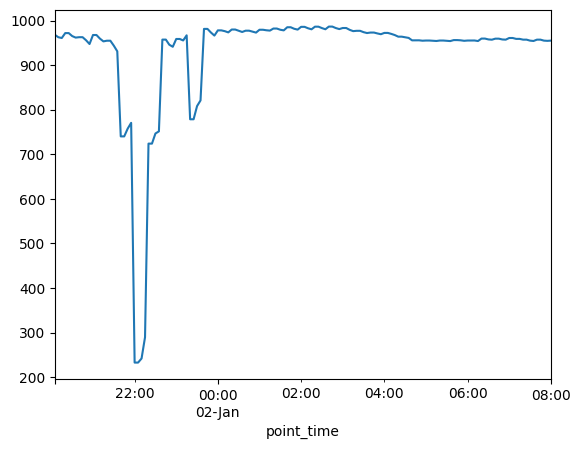

In [ ]:
# this is really just to see what it decided to do -- for audit purposes.
# We assume that it follows each new schedule produced.
# Only one parameters updates: remaining time required
# You also need a timer or a list of future requery times are based on preferred frequency.
# Once the timer runs out and is reset OR the system time == next requery time, the a new schedule is produced.

fitted_recalculator.get_combined_schedule()["pred_moer"].plot(kind="line")

<Axes: xlabel='point_time'>

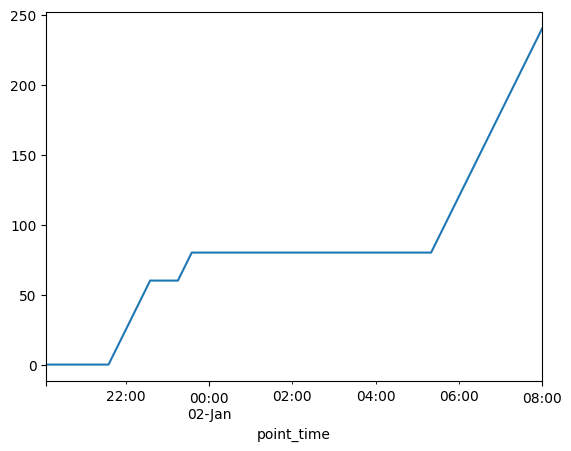

In [100]:
fitted_recalculator.get_combined_schedule()["usage"].cumsum().plot(kind="line")